# Prep the DMS + Octet data for tdms training

In [1]:
# Imports
import pickle
import json
from functools import reduce
from datetime import date
from collections import defaultdict

import pandas as pd
import numpy as np
from Bio.Seq import Seq
from Bio import SeqIO
# import binarymap

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

## 1: Merge and clean raw data

In [2]:
# directory where all all input and output is organized
data_dir = "../nextflow/data/torchdms/raw-dms"
prepped_dir = "../nextflow/data/torchdms/prepped-dms"

# other relative paths
wt_seq_path = f"{data_dir}/wildtype_sequence.fasta"
raw_bind = f"{data_dir}/bc_binding.csv"
raw_expr = f"{data_dir}/bc_expression.csv"
raw_poly = f"{data_dir}/bc_polyspecificity.csv"

In [3]:
bind = pd.read_csv(raw_bind)
bind

,library,barcode,target,variant_class,aa_substitutions,n_aa_substitutions,TiteSeq_avgcount,log10Ka
0,lib1,AAAAAAAAAACACCGG,CGG_naive,1 nonsynonymous,L200T,1,26.923275,8.846567
1,lib1,AAAAAAAAAACATGAG,CGG_naive,1 nonsynonymous,Q16W,1,18.782567,9.970348
2,lib1,AAAAAAAAAAGCGACG,CGG_naive,1 nonsynonymous,V156H,1,3.747787,NaN
3,lib1,AAAAAAAAAAGGAAAG,CGG_naive,1 nonsynonymous,V110G,1,24.172350,10.226335
4,lib1,AAAAAAAAAATATAGA,CGG_naive,1 nonsynonymous,Y47P,1,4.382351,NaN
...,...,...,...,...,...,...,...,...
192424,lib2,TTTTTTCTAAACAAGT,CGG_naive,1 nonsynonymous,R181T,1,8.318660,NaN
192425,lib2,TTTTTTGACCCCCCCA,CGG_naive,>1 nonsynonymous,A178T S179T,2,123.106203,10.640967
192426,lib2,TTTTTTGCTGTGTATC,CGG_naive,wildtype,NaN,0,54.904519,10.513270
192427,lib2,TTTTTTGGTGAAAGTT,CGG_naive,1 nonsynonymous,A152I,1,17.261457,10.685635


In [4]:
len(bind.query("library=='lib1'").barcode.unique())+ len(bind.query("library=='lib2'").barcode.unique())

192429

In [5]:
len(bind.query("n_aa_substitutions == 1").aa_substitutions.unique())

4266

In [6]:
raw_cols = ['log10Ka', 'expression', 'polyspecificity_02']
raw_dfs = [pd.read_csv(raw_bind), pd.read_csv(raw_expr), pd.read_csv(raw_poly)]
new_cols = ["bind", "stab", "poly"]

In [7]:
# Sequence information from Tyler's repo
record = SeqIO.read(wt_seq_path, 'fasta')
dna_seq = record.seq     
wtseq = dna_seq.translate()
len(wtseq)

235

**now let's merge the scores into a single df**

In [8]:
full_df = reduce(
        lambda l, r: pd.merge(l, r, how='inner',
            on=['library','target', 'barcode', 'variant_class', 'aa_substitutions','n_aa_substitutions'],
            sort=False
        ),
        raw_dfs,
    ).rename(dict(zip(raw_cols, new_cols)), axis=1)

full_df.aa_substitutions = full_df.aa_substitutions.fillna(' ')
full_df.n_aa_substitutions = [len(s.split()) for s in full_df.aa_substitutions.values]

In [9]:
full_df[new_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192429 entries, 0 to 192428
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bind    140191 non-null  float64
 1   stab    175070 non-null  float64
 2   poly    150390 non-null  float64
dtypes: float64(3)
memory usage: 5.9 MB


In [10]:
full_df

,library,barcode,target,variant_class,aa_substitutions,n_aa_substitutions,TiteSeq_avgcount,bind,expr_count,stab,psr_count_01,polyspecificity_01,psr_count_02,poly,psr_count_03,polyspecificity_03,psr_count_04,polyspecificity_04,psr_count_05,polyspecificity_05
0,lib1,AAAAAAAAAACACCGG,CGG_naive,1 nonsynonymous,L200T,1,26.923275,8.846567,64.345900,9.007342,20.301958,8.213285,35.671249,7.058303,NaN,NaN,NaN,NaN,NaN,NaN
1,lib1,AAAAAAAAAACATGAG,CGG_naive,1 nonsynonymous,Q16W,1,18.782567,9.970348,33.779443,10.054682,27.071457,6.853904,NaN,NaN,18.351322,6.556966,12.095667,5.551479,NaN,NaN
2,lib1,AAAAAAAAAAGCGACG,CGG_naive,1 nonsynonymous,V156H,1,3.747787,NaN,11.465479,9.220030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,lib1,AAAAAAAAAAGGAAAG,CGG_naive,1 nonsynonymous,V110G,1,24.172350,10.226335,45.107022,10.478803,14.308368,9.211674,16.077428,7.693180,24.880724,6.723436,30.126559,6.385712,48.877433,4.934794
4,lib1,AAAAAAAAAATATAGA,CGG_naive,1 nonsynonymous,Y47P,1,4.382351,NaN,19.305637,10.435562,22.557213,8.301154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192424,lib2,TTTTTTCTAAACAAGT,CGG_naive,1 nonsynonymous,R181T,1,8.318660,NaN,14.913681,10.228599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.074951,4.990846
192425,lib2,TTTTTTGACCCCCCCA,CGG_naive,>1 nonsynonymous,A178T S179T,2,123.106203,10.640967,296.932441,10.324724,152.330109,7.550733,129.643565,6.568334,139.608097,6.747056,100.111162,6.242673,169.660703,5.017981
192426,lib2,TTTTTTGCTGTGTATC,CGG_naive,wildtype,,0,54.904519,10.513270,71.956558,10.461418,75.248426,7.505175,41.122444,7.535577,49.722364,6.791951,20.452283,6.673595,67.886460,4.906440
192427,lib2,TTTTTTGGTGAAAGTT,CGG_naive,1 nonsynonymous,A152I,1,17.261457,10.685635,26.048021,9.903753,31.433015,7.256333,42.280399,6.908743,NaN,NaN,NaN,NaN,NaN,NaN


**lets grab tylers final variant scores and compare**

In [11]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-128
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-128
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-128


In [12]:
dms_df.columns

Index(['target', 'wildtype', 'position', 'position_IMGT', 'chain',
       'annotation', 'mutant', 'codon', 'single_nt', 'bind_CGG',
       'delta_bind_CGG', 'n_bc_bind_CGG', 'n_libs_bind_CGG', 'bind_TuGG',
       'delta_bind_TuGG', 'n_bc_bind_TuGG', 'n_libs_bind_TuGG', 'expr',
       'delta_expr', 'n_bc_expr', 'n_libs_expr', 'psr', 'delta_psr',
       'n_bc_psr', 'n_libs_psr', 'WT', 'site'],
      dtype='object')

In [13]:
my_df = full_df.copy()
tylers = dms_df.copy()

In [14]:
len(tylers.position.unique()) 

220

In [15]:
tylers.query("bind_CGG.isnull() & WT == False")

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
I2(L)F,CGG_naive,I,129,2,L,FWRL1,F,ATT,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,L-002
I2(L)L,CGG_naive,I,129,2,L,FWRL1,L,ATT,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,L-002
Q6(L)G,CGG_naive,Q,133,6,L,FWRL1,G,CAG,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,L-006
Q6(L)I,CGG_naive,Q,133,6,L,FWRL1,I,CAG,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,L-006
Q6(L)L,CGG_naive,Q,133,6,L,FWRL1,L,CAG,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,L-006
Q6(L)Y,CGG_naive,Q,133,6,L,FWRL1,Y,CAG,False,NaN,...,10.29253,-0.12546,3.0,1.0,7.38046,0.64424,3.0,1.0,False,L-006
S7(L)C,CGG_naive,S,134,7,L,FWRL1,C,TCT,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,L-007
S7(L)D,CGG_naive,S,134,7,L,FWRL1,D,TCT,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,L-007
S7(L)F,CGG_naive,S,134,7,L,FWRL1,F,TCT,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,L-007


In [16]:
print(f"After merging the scores, I see {len(my_df.bind)}")
print(f"In tylers final variant scores, I see {len(tylers.bind_CGG)}")

After merging the scores, I see 192429
In tylers final variant scores, I see 4400


**We only drop examples where non of the targets have valid measurements (i.e. notnull)**

In [17]:
to_drop_query = " | ".join([f"{target}.notnull()" for target in new_cols])

full_df = full_df.query(to_drop_query)

In [18]:
full_df[new_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177939 entries, 0 to 192428
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bind    140191 non-null  float64
 1   stab    175070 non-null  float64
 2   poly    150390 non-null  float64
dtypes: float64(3)
memory usage: 5.4 MB


In [19]:
full_df.variant_class.value_counts()

1 nonsynonymous     141592
wildtype             21560
>1 nonsynonymous     13493
stop                   682
synonymous             612
Name: variant_class, dtype: int64

In [20]:
full_df.columns

Index(['library', 'barcode', 'target', 'variant_class', 'aa_substitutions',
       'n_aa_substitutions', 'TiteSeq_avgcount', 'bind', 'expr_count', 'stab',
       'psr_count_01', 'polyspecificity_01', 'psr_count_02', 'poly',
       'psr_count_03', 'polyspecificity_03', 'psr_count_04',
       'polyspecificity_04', 'psr_count_05', 'polyspecificity_05'],
      dtype='object')

In [21]:
missing_single_muts = []
for idx, sm_row in tylers.iterrows():
    if sm_row.WT: continue
    mutant = f"{sm_row.wildtype}{sm_row.position}{sm_row.mutant}"
    if mutant not in set(full_df.aa_substitutions):
        missing_single_muts.append(mutant)
print(f"Across all single mutants in our dataset, the missing mutations are: {missing_single_muts}")

Across all single mutants in our dataset, the missing mutations are: ['I129F', 'I129L', 'S134R']


In [22]:
light_chain_positions = len(tylers.query("chain == 'L'").position_IMGT.unique())
heavy_chain_positions = len(tylers.query("chain == 'H'").position_IMGT.unique())

In [23]:
print(f"There are {heavy_chain_positions} light chain pos, and {light_chain_positions} heavy chain pos")

There are 112 light chain pos, and 108 heavy chain pos


In [24]:
print(f"So tyler has {len(tylers)} total final variant scores, "
      f"which is all 20 possible amino acids at all non linker sites."
      f"(20 * (112 + 108)) {20 * (112+108)}")

So tyler has 4400 total final variant scores, which is all 20 possible amino acids at all non linker sites.(20 * (112 + 108)) 4400


In [25]:
19 * (112+108)

4180

In [26]:
for i in range(len(tylers.position)):
    ith = sorted(list(set(tylers.position)))[i]
    if i != ith - 1: print(i); break

112


In [27]:
heavy = sorted(list(set(tylers.position)))[:i]
light = sorted(list(set(tylers.position)))[i:]

print("heavy", len(heavy), heavy)
print("light", len(light), light)

heavy 112 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]
light 108 [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 2

In [28]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,124,CTA,FWRL4
232,E,L,125,GAA,FWRL4
233,I,L,126,ATA,FWRL4


In [29]:
assert np.all(list(pos_df.index) == list(range(1, 236))) 

**Now add both aa_substitutions, and aa_substitutions_IMGT**

In [30]:
# IMGT format: A5(L)T
# GE modeling format: T267G
# this could be done a little more cleanly with regex

def pos_to_imgt(pos_df:pd.DataFrame, aa_sub:str):
    """convert single ge modeling format to imgt format
    using the position map dataframe"""
    
    wt_aa_seq_series = pos_df.amino_acid
    pos = int(aa_sub[1:-1])
    wildtype, mutant = aa_sub[0], aa_sub[-1]
    assert wt_aa_seq_series[pos] == wildtype
    chain_site, chain = pos_df.loc[pos, ["site", "chain"]]  
    return f"{wildtype}{chain_site}({chain}){mutant}"
    

def imgt_to_pos(pos_df:pd.DataFrame, aa_sub:str):
    """convert single imgt format to ge modeling format
    using the position map dataframe"""
    
    wt_aa_seq_series = pos_df.amino_acid
    chain = aa_sub[-3]
    pos = int(aa_sub[1:-4])
    wildtype = aa_sub[0]
    mutant = aa_sub[-1]
    idx = pos_df.index[(pos_df.site == pos) & (pos_df.chain == chain)]
    assert len(idx) == 1
    idx = idx[0]
    assert wt_aa_seq_series[idx] == wildtype
    return f"{wildtype}{idx}{mutant}"


def pos_mut_to_seq(pos_df:str, aa_subs_string:str):
    """convert ge modeling format string list 
    to the variant aa sequence"""

    ret_wt_aa_seq_series = pos_df.amino_acid.copy()
    for aa_sub in aa_subs_string.split():
        pos = int(aa_sub[1:-1])
        wildtype, mutant = aa_sub[0], aa_sub[-1]
        assert ret_wt_aa_seq_series[pos] == wildtype
        ret_wt_aa_seq_series[pos] = mutant
    
    return "".join(ret_wt_aa_seq_series.values)

**quick sanity check to make sure that the mut conversions are inverses of each other**

In [31]:
for imgt_mut_str in tylers.query("WT == False").index:
    assert imgt_mut_str == pos_to_imgt(pos_df, imgt_to_pos(pos_df, imgt_mut_str))

**quick sanity check to make sure that the mut to seq conversions are correct**

In [32]:
aa_sub = imgt_to_pos(pos_df, imgt_mut_str)
pos = int(aa_sub[1:-1])
wildtype, mutant = aa_sub[0], aa_sub[-1]
str_idx = pos-1
assert pos_mut_to_seq(pos_df, aa_sub)[str_idx] == mutant

In [33]:
wt = "".join(pos_df.amino_acid.copy().values)
full_df = full_df.assign(aa_substitutions_IMGT = "")
full_df = full_df.assign(aa_sequence = wt)
full_df

,library,barcode,target,variant_class,aa_substitutions,n_aa_substitutions,TiteSeq_avgcount,bind,expr_count,stab,...,psr_count_02,poly,psr_count_03,polyspecificity_03,psr_count_04,polyspecificity_04,psr_count_05,polyspecificity_05,aa_substitutions_IMGT,aa_sequence
0,lib1,AAAAAAAAAACACCGG,CGG_naive,1 nonsynonymous,L200T,1,26.923275,8.846567,64.345900,9.007342,...,35.671249,7.058303,NaN,NaN,NaN,NaN,NaN,NaN,,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
1,lib1,AAAAAAAAAACATGAG,CGG_naive,1 nonsynonymous,Q16W,1,18.782567,9.970348,33.779443,10.054682,...,NaN,NaN,18.351322,6.556966,12.095667,5.551479,NaN,NaN,,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
2,lib1,AAAAAAAAAAGCGACG,CGG_naive,1 nonsynonymous,V156H,1,3.747787,NaN,11.465479,9.220030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
3,lib1,AAAAAAAAAAGGAAAG,CGG_naive,1 nonsynonymous,V110G,1,24.172350,10.226335,45.107022,10.478803,...,16.077428,7.693180,24.880724,6.723436,30.126559,6.385712,48.877433,4.934794,,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
4,lib1,AAAAAAAAAATATAGA,CGG_naive,1 nonsynonymous,Y47P,1,4.382351,NaN,19.305637,10.435562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192424,lib2,TTTTTTCTAAACAAGT,CGG_naive,1 nonsynonymous,R181T,1,8.318660,NaN,14.913681,10.228599,...,NaN,NaN,NaN,NaN,NaN,NaN,11.074951,4.990846,,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
192425,lib2,TTTTTTGACCCCCCCA,CGG_naive,>1 nonsynonymous,A178T S179T,2,123.106203,10.640967,296.932441,10.324724,...,129.643565,6.568334,139.608097,6.747056,100.111162,6.242673,169.660703,5.017981,,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
192426,lib2,TTTTTTGCTGTGTATC,CGG_naive,wildtype,,0,54.904519,10.513270,71.956558,10.461418,...,41.122444,7.535577,49.722364,6.791951,20.452283,6.673595,67.886460,4.906440,,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
192427,lib2,TTTTTTGGTGAAAGTT,CGG_naive,1 nonsynonymous,A152I,1,17.261457,10.685635,26.048021,9.903753,...,42.280399,6.908743,NaN,NaN,NaN,NaN,NaN,NaN,,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...


**add all the aa substitution conversions, along with the mutant sequence - this is quite slow. Should we just do this after collapsing mutants - probably much faster. Or you could do some caching to speed things up**

In [34]:
imgt_conv_cache = defaultdict(str)
mut_seq_cache = defaultdict(str)

for idx, variant_row in full_df.iterrows():
    all_mutations = variant_row.aa_substitutions

    if all_mutations not in mut_seq_cache:
        mut_seq_cache[all_mutations] = pos_mut_to_seq(pos_df, all_mutations)
    full_df.loc[idx, "aa_sequence"] = mut_seq_cache[all_mutations]
     
    if all_mutations not in imgt_conv_cache:
        converted_imgt_mutations = []
        for mutation in all_mutations.split():
            converted_imgt_mutations.append(pos_to_imgt(pos_df, mutation))
        imgt_conv_string = " ".join(converted_imgt_mutations)
        imgt_conv_cache[all_mutations] = imgt_conv_string
        
    full_df.loc[idx, "aa_substitutions_IMGT"] = imgt_conv_cache[all_mutations]

**Sanity check that all mutations strings have a one to one mapping with aa_sequence -- That would basically make sure the mutations all appear in the same order**

In [35]:
full_df

,library,barcode,target,variant_class,aa_substitutions,n_aa_substitutions,TiteSeq_avgcount,bind,expr_count,stab,...,psr_count_02,poly,psr_count_03,polyspecificity_03,psr_count_04,polyspecificity_04,psr_count_05,polyspecificity_05,aa_substitutions_IMGT,aa_sequence
0,lib1,AAAAAAAAAACACCGG,CGG_naive,1 nonsynonymous,L200T,1,26.923275,8.846567,64.345900,9.007342,...,35.671249,7.058303,NaN,NaN,NaN,NaN,NaN,NaN,L89(L)T,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
1,lib1,AAAAAAAAAACATGAG,CGG_naive,1 nonsynonymous,Q16W,1,18.782567,9.970348,33.779443,10.054682,...,NaN,NaN,18.351322,6.556966,12.095667,5.551479,NaN,NaN,Q17(H)W,EVQLQESGPSLVKPSWTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
2,lib1,AAAAAAAAAAGCGACG,CGG_naive,1 nonsynonymous,V156H,1,3.747787,NaN,11.465479,9.220030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V29(L)H,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
3,lib1,AAAAAAAAAAGGAAAG,CGG_naive,1 nonsynonymous,V110G,1,24.172350,10.226335,45.107022,10.478803,...,16.077428,7.693180,24.880724,6.723436,30.126559,6.385712,48.877433,4.934794,V126(H)G,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
4,lib1,AAAAAAAAAATATAGA,CGG_naive,1 nonsynonymous,Y47P,1,4.382351,NaN,19.305637,10.435562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y52(H)P,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192424,lib2,TTTTTTCTAAACAAGT,CGG_naive,1 nonsynonymous,R181T,1,8.318660,NaN,14.913681,10.228599,...,NaN,NaN,NaN,NaN,NaN,NaN,11.074951,4.990846,R67(L)T,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
192425,lib2,TTTTTTGACCCCCCCA,CGG_naive,>1 nonsynonymous,A178T S179T,2,123.106203,10.640967,296.932441,10.324724,...,129.643565,6.568334,139.608097,6.747056,100.111162,6.242673,169.660703,5.017981,A57(L)T S65(L)T,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
192426,lib2,TTTTTTGCTGTGTATC,CGG_naive,wildtype,,0,54.904519,10.513270,71.956558,10.461418,...,41.122444,7.535577,49.722364,6.791951,20.452283,6.673595,67.886460,4.906440,,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
192427,lib2,TTTTTTGGTGAAAGTT,CGG_naive,1 nonsynonymous,A152I,1,17.261457,10.685635,26.048021,9.903753,...,42.280399,6.908743,NaN,NaN,NaN,NaN,NaN,NaN,A25(L)I,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...


## 2: WT summary stats

now, we'll take a look at the wildtype dummary stats to get an idea of the variance among many replicates, and to get an idea of difference when compared to mutants of various strata (N-mutations). This is because we want to predict delta's (change in affinity) of mutants when compared to the wildtype. We also want to know about any batch-specific differences between the two libraries being used

In [36]:
# non-synonymous mutants count as wildtype.
wt_df = full_df.query("n_aa_substitutions == 0")

In [37]:
wt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22172 entries, 10 to 192426
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   library                22172 non-null  object 
 1   barcode                22172 non-null  object 
 2   target                 22172 non-null  object 
 3   variant_class          22172 non-null  object 
 4   aa_substitutions       22172 non-null  object 
 5   n_aa_substitutions     22172 non-null  int64  
 6   TiteSeq_avgcount       22172 non-null  float64
 7   bind                   18027 non-null  float64
 8   expr_count             21769 non-null  float64
 9   stab                   21768 non-null  float64
 10  psr_count_01           19662 non-null  float64
 11  polyspecificity_01     19237 non-null  float64
 12  psr_count_02           19810 non-null  float64
 13  poly                   19450 non-null  float64
 14  psr_count_03           19122 non-null  float64
 15  

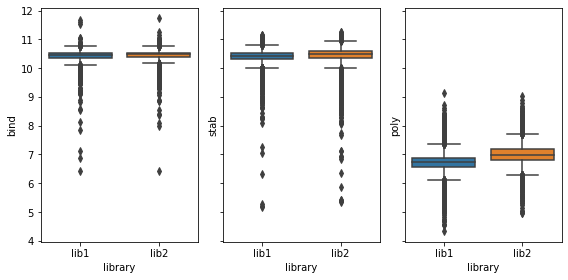

In [38]:
fig, ax = plt.subplots(1,3, figsize=[8,4],sharex=True, sharey=True)
for col, metric in enumerate(new_cols):
    sns.boxplot(x="library", y=metric, data=wt_df, ax=ax[col])
plt.tight_layout()
plt.show()

## 3: Mutant summary stats

In [39]:
# calculate deltas from wt
mutants = full_df.query("n_aa_substitutions != 0").copy()

In [40]:
mutants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155767 entries, 0 to 192428
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   library                155767 non-null  object 
 1   barcode                155767 non-null  object 
 2   target                 155767 non-null  object 
 3   variant_class          155767 non-null  object 
 4   aa_substitutions       155767 non-null  object 
 5   n_aa_substitutions     155767 non-null  int64  
 6   TiteSeq_avgcount       155767 non-null  float64
 7   bind                   122164 non-null  float64
 8   expr_count             153320 non-null  float64
 9   stab                   153302 non-null  float64
 10  psr_count_01           133385 non-null  float64
 11  polyspecificity_01     129359 non-null  float64
 12  psr_count_02           134151 non-null  float64
 13  poly                   130940 non-null  float64
 14  psr_count_03           129378 non-nu

## 4: Calculate delta's from wildtype average.

$\Delta$ $M_{Pi}$ = $M_{Pi}$ - ($1/N$ $\sum_{n=0}^{N}{WT}_{Pn}$)

In [41]:
lib_wt_bind = {}
for lib, lib_df in wt_df.groupby("library"):
    print(lib)
    for metric in new_cols:
        mean_lib_metric = round(np.mean(lib_df[metric]), 5)
        if metric == "bind": lib_wt_bind[lib] = mean_lib_metric
        print(f"  mean {metric}: {mean_lib_metric}")
        mutants[f"delta_{metric}"] = mutants[metric] - mean_lib_metric

lib1
  mean bind: 10.41134
  mean stab: 10.39789
  mean poly: 6.72648
lib2
  mean bind: 10.44189
  mean stab: 10.44624
  mean poly: 7.01713


In [42]:
lib_wt_bind

{'lib1': 10.41134, 'lib2': 10.44189}

In [43]:
overall_wt_bind = sum(lib_wt_bind.values()) / len(lib_wt_bind)
overall_wt_bind

10.426615

## 5: Bacode replicate summary stats 

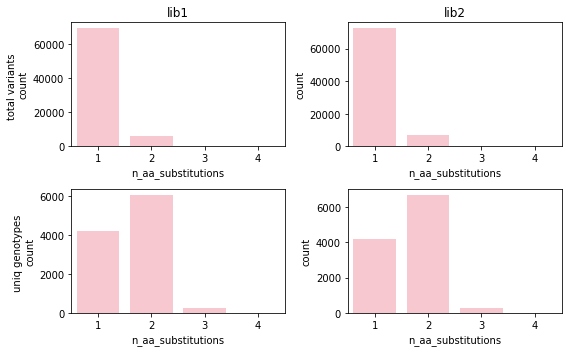

In [44]:
# How many unique variants are in the library by codon-substution number?
fig, ax = plt.subplots(2,2, figsize=[8, 5])
for i,(lib, lib_df) in enumerate(mutants.groupby('library')):
    uniq_geno_lib_df = lib_df.groupby("aa_substitutions").first()
    sns.countplot(data=uniq_geno_lib_df, x='n_aa_substitutions', color="pink", ax=ax[1, i])
    sns.countplot(data=lib_df, x="n_aa_substitutions", color="pink", ax=ax[0, i])
    ax[0, i].set_title(lib)

ax[0, 0].set_ylabel("total variants \ncount")
ax[1, 0].set_ylabel("uniq genotypes \ncount")
plt.tight_layout()
plt.show()

## 6: Aggragate barcodes for mutants

In [45]:
id_vars = ['library','aa_substitutions','aa_substitutions_IMGT','aa_sequence', 'n_aa_substitutions']
mean_collapsed_mutants = mutants.groupby(id_vars).mean().reset_index()
mean_collapsed_mutants
# ge_prepped_df = mean_collapsed_mutants[[f"delta_{metric}" for metric in new_cols] + id_vars]
# ge_prepped_df

,library,aa_substitutions,aa_substitutions_IMGT,aa_sequence,n_aa_substitutions,TiteSeq_avgcount,bind,expr_count,stab,psr_count_01,...,poly,psr_count_03,polyspecificity_03,psr_count_04,polyspecificity_04,psr_count_05,polyspecificity_05,delta_bind,delta_stab,delta_poly
0,lib1,A104C,A120(H)C,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,49.578387,10.447823,82.591268,10.367013,50.726303,...,7.551130,53.386712,6.853603,52.093435,6.157639,65.581008,4.765981,0.005933,-0.079227,0.534000
1,lib1,A104C A173E,A120(H)C A52(L)E,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,24.531052,10.096348,40.163237,9.793465,19.480077,...,7.991324,10.067112,7.093227,26.882459,6.091449,22.690137,NaN,-0.345542,-0.652775,0.974194
2,lib1,A104C F137L,A120(H)C F10(L)L,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,14.702414,10.705720,NaN,NaN,16.172252,...,NaN,13.068640,5.870970,NaN,NaN,NaN,NaN,0.263830,NaN,NaN
3,lib1,A104C G105V,A120(H)C G121(H)V,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,108.587279,9.383961,188.963661,9.837922,67.511194,...,8.826508,65.444193,8.520774,51.164617,8.077361,73.597798,4.780549,-1.057929,-0.608318,1.809378
4,lib1,A104C G118S,A120(H)C G<NA>(link)S,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,22.008064,10.277952,55.183723,10.625839,34.390626,...,7.108713,33.005467,6.954956,34.198187,5.923384,29.173034,NaN,-0.163938,0.179599,0.091583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21762,lib2,Y94V,Y103(H)V,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,37.879106,10.843375,76.883739,10.182583,43.318695,...,8.805133,37.886363,8.755452,38.893079,8.010151,54.422384,4.901956,0.401485,-0.263657,1.788003
21763,lib2,Y94V G113C,Y103(H)V G<NA>(link)C,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,115.879538,10.481170,290.686885,9.974273,136.355102,...,8.858786,93.235978,8.771709,102.147815,8.279465,195.131987,4.996674,0.039280,-0.471967,1.841656
21764,lib2,Y94V S112G,Y103(H)V S128(H)G,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,61.421075,10.920127,145.864683,10.226043,78.482483,...,8.344829,44.631603,8.429372,54.373341,7.345149,108.065859,4.919758,0.478237,-0.220197,1.327699
21765,lib2,Y94W,Y103(H)W,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,67.784501,10.246369,113.876145,10.378745,82.277289,...,7.044660,68.239727,6.841593,70.715918,6.214957,78.245251,4.878749,-0.195521,-0.067495,0.027530


**Look at correlation of mutants between two library averages**

In [46]:
lib1 = mean_collapsed_mutants.query("library == 'lib1'")
lib2 = mean_collapsed_mutants.query("library == 'lib2'")
merged_genos = lib1.merge(lib2, on="aa_substitutions" , how="inner", suffixes=("_lib1", "_lib2"))

In [47]:
merged_genos

,library_lib1,aa_substitutions,aa_substitutions_IMGT_lib1,aa_sequence_lib1,n_aa_substitutions_lib1,TiteSeq_avgcount_lib1,bind_lib1,expr_count_lib1,stab_lib1,psr_count_01_lib1,...,poly_lib2,psr_count_03_lib2,polyspecificity_03_lib2,psr_count_04_lib2,polyspecificity_04_lib2,psr_count_05_lib2,polyspecificity_05_lib2,delta_bind_lib2,delta_stab_lib2,delta_poly_lib2
0,lib1,A104C,A120(H)C,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,49.578387,10.447823,82.591268,10.367013,50.726303,...,7.654280,36.433270,7.216823,39.342351,6.753886,44.497460,4.923831,-0.089694,-0.035562,0.637150
1,lib1,A104D,A120(H)D,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,75.051408,10.277415,128.853357,10.289612,95.564164,...,6.913044,82.402873,6.670900,64.581474,6.224340,77.722212,4.925814,-0.115443,0.018419,-0.104086
2,lib1,A104E,A120(H)E,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,51.287967,10.325204,99.383819,10.394809,64.923372,...,7.049743,49.930828,6.674807,55.127800,6.119182,80.737275,4.838915,-0.078873,-0.016599,0.032613
3,lib1,A104F,A120(H)F,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,48.136130,10.336783,83.954492,10.389167,77.722993,...,7.255071,39.659749,6.917161,48.342551,6.224614,50.700208,4.860229,-0.049601,0.072349,0.237941
4,lib1,A104G,A120(H)G,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,64.756193,10.362082,102.342320,10.439436,86.942160,...,6.913414,63.607128,6.775178,57.323218,6.144151,76.270606,4.878935,-0.051115,-0.086089,-0.103716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4221,lib1,Y94R,Y103(H)R,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,32.227422,10.476912,75.196176,9.814012,36.722235,...,9.002440,35.071928,8.515975,29.741583,8.137195,56.808513,4.855408,0.054447,-0.854703,1.985310
4222,lib1,Y94S,Y103(H)S,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,44.257156,10.585385,106.767454,10.043330,51.735512,...,8.679766,28.296279,8.690792,31.664939,7.651831,51.494475,4.881780,0.131642,-0.415571,1.662636
4223,lib1,Y94T,Y103(H)T,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,43.476172,10.828965,97.609366,10.043989,49.020802,...,8.843797,48.281052,8.615356,46.388924,7.892510,79.415735,4.909834,0.354068,-0.403674,1.826667
4224,lib1,Y94V,Y103(H)V,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,49.197102,10.822766,108.247729,10.089212,57.693395,...,8.805133,37.886363,8.755452,38.893079,8.010151,54.422384,4.901956,0.401485,-0.263657,1.788003


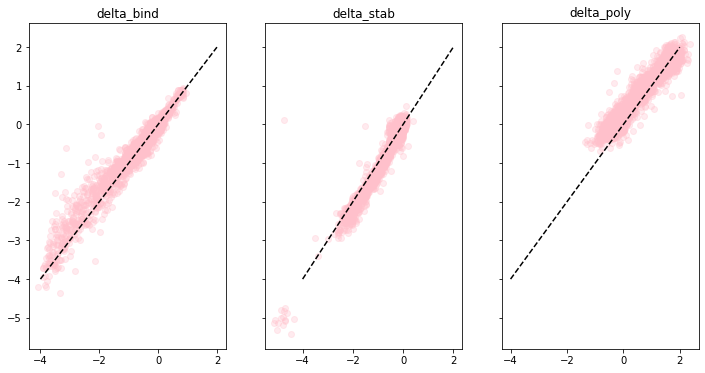

In [48]:
fig, ax = plt.subplots(1,3, figsize=[12, 6], sharey=True)
for i, pheno in enumerate([f"delta_{metric}" for metric in new_cols]):
    ax[i].scatter(
        merged_genos[f"{pheno}_lib1"], 
        merged_genos[f"{pheno}_lib2"],
        alpha = 0.3,
        color="pink"
    )
    ax[i].set_title(pheno)
    ax[i].plot((-4, 2), (-4, 2), 'k--')
    
fig.savefig("dms-lib-pheno-scatter.png")
plt.show()

17,615 total examples in mean collapsed where delta bind, stab, and poly are non null.

In [49]:
# id_vars = ['library','aa_substitutions','aa_substitutions_IMGT','aa_sequence']
# mean_collapsed_mutants = mutants.groupby(id_vars).mean().reset_index()
# ge_prepped_df = mean_collapsed_mutants[[f"delta_{metric}" for metric in new_cols] + id_vars]
# ge_prepped_df

In [50]:
datas = {
    "Mutants\n(separate)" :  mutants,
    "Mutants\n(Collapsed By Barcode)": mean_collapsed_mutants,
}

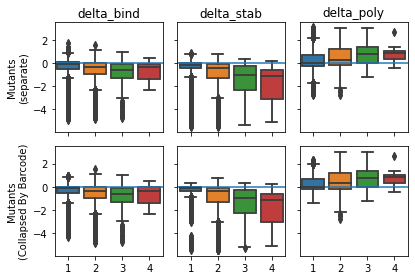

In [51]:
new_cols_delta = [f"delta_{c}" for c in new_cols]

fig, ax = plt.subplots(len(datas),3, figsize=[6, 4], sharex=True, sharey=True)
for col, metric in enumerate(new_cols_delta):
    for row, (key, value) in enumerate(datas.items()):
        cur_ax = ax[row, col] if len(datas) > 1 else ax[col]
        sns.boxplot(x="n_aa_substitutions", y=metric, data=value, ax=cur_ax)
        sns.boxplot(x="n_aa_substitutions", y=metric, data=value, ax=cur_ax)
        cur_ax.set_ylabel("")
        cur_ax.set_xlabel("")
        if row == 0: cur_ax.set_title(metric)
        if col == 0: cur_ax.set_ylabel(key)
        cur_ax.axhline()

fig.xlabel = "N AA Subs"
plt.tight_layout()

plt.show()

# 8: octet data

**load the octet data and convert the mutations to tdms format**

In [52]:
octet_df = pd.read_csv(f"{data_dir}/octet_data.csv")
octet_df

,ID,HCmut,LCmut,aa_mut_total,deltaKd_additive_foldchange,deltaKd_additive,octet_Kd_foldchange_avg,kd,kon,kdis,R^2
0,#26 Fab4,"K49R, Y58F",A40G,3,7.462082,0.87286,6.364276,2.840000e-09,126300,0.000359,0.9993
1,A40G,GL,A40G,1,7.172326,0.85566,6.952912,4.210000e-09,90900,0.000383,0.9997
2,A40V,GL,A40V,1,0.193201,-0.71399,0.642593,5.400000e-08,142000,0.007670,0.9746
3,"A40V, N108D",GL,"A40V, N108D",2,0.031422,-1.50277,0.376934,7.110000e-08,111000,0.007920,0.9266
4,D28A,D28A,GL,1,6.835810,0.83479,5.774278,3.810000e-09,225000,0.000858,0.9944
5,EH1,"D28A, K44R, S64G","A40G, Y42F, A52S, Q105H, N108Y",8,2558.998315,3.40807,308.192458,7.690000e-11,933000,0.000072,0.9919
6,EH2,"D28A, K49R, S64G","A40G, Y42F, A52S, Q105H, N108Y",8,2154.269337,3.33330,383.495146,6.180000e-11,1030000,0.000063,0.9947
7,EH3,"D28A, K44R, K49R, S64G","A40G, Y42F, A52S, Q105H, N108Y",9,2499.769702,3.39790,361.280488,6.560000e-11,1050000,0.000069,0.9900
8,GL,GL,GL,0,1.000000,0.00000,1.000000,2.600000e-08,86700,0.002260,0.9900
9,K44R,K44R,GL,1,1.160379,0.06460,0.986547,2.230000e-08,152000,0.003400,0.9950


**cleanup octet dataframe to match dms variants**

In [53]:
# cleanup
wt = "".join(pos_df.amino_acid.copy().values)
octet_df = octet_df.assign(aa_substitutions_IMGT = "")
octet_df = octet_df.assign(aa_substitutions = "")
octet_df = octet_df.assign(aa_sequence = wt)

In [54]:
for row_idx, row in octet_df.iterrows():
    igh_mutations = [f"{(y := x.rstrip(','))[:-1]}(H){y[-1]}".rstrip(",") for x in row.HCmut.split() if "GL" not in x]
    igk_mutations = [f"{(y := x.rstrip(','))[:-1]}(L){y[-1]}".rstrip(",") for x in row.LCmut.split() if "GL" not in x]
    
    all_mutations = igh_mutations + igk_mutations
    octet_df.loc[row_idx, "aa_substitutions_IMGT"] = " ".join(all_mutations)
    
    converted_mutations = []
    for mutation in all_mutations:
        converted_mutations.append(imgt_to_pos(pos_df, mutation))  
    
    conv_muts_string = " ".join(converted_mutations)
    octet_df.loc[row_idx, "aa_substitutions"] = conv_muts_string
    octet_df.loc[row_idx, "aa_sequence"] = pos_mut_to_seq(pos_df, conv_muts_string)

octet_df = octet_df.assign(delta_bind = np.log10(octet_df.octet_Kd_foldchange_avg))
octet_df = octet_df.assign(bind = np.log10(1/octet_df["kd "]))


octet_df = octet_df.assign(library = "octet")
octet_df = octet_df[
    ["library", "delta_bind", "bind", "aa_substitutions", "aa_substitutions_IMGT", "aa_mut_total", "aa_sequence"]
].rename({"aa_mut_total":"n_aa_substitutions"}, axis=1)

In [55]:
# octet_df.to_csv(f"{prepped_dir}/octet_data_prepped.csv", index=True)

In [56]:
octet_df.n_aa_substitutions.value_counts().sort_index()

0     1
1    13
2     2
3     2
4     3
5     3
8     3
9     1
Name: n_aa_substitutions, dtype: int64

**merge it with the training data**

In [57]:
# octet_df_tdms = octet_df[["library", "aa_sequence","delta_bind","aa_substitutions","aa_substitutions_IMGT", "aa_mut_total"]].rename({"aa_mut_total":"n_aa_substitutions"}, axis=1)
# octet_df_tdms

In [58]:
tdms_data_dms = mean_collapsed_mutants[
    ["library", "aa_substitutions", "aa_substitutions_IMGT", 
     "n_aa_substitutions", "bind", "delta_bind", "delta_stab", "delta_poly", "aa_sequence"]
]
tdms_data_dms_octet = pd.concat([tdms_data_dms, octet_df], ignore_index=True)
tdms_data_dms_octet

,library,aa_substitutions,aa_substitutions_IMGT,n_aa_substitutions,bind,delta_bind,delta_stab,delta_poly,aa_sequence
0,lib1,A104C,A120(H)C,1,10.447823,0.005933,-0.079227,0.534000,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
1,lib1,A104C A173E,A120(H)C A52(L)E,2,10.096348,-0.345542,-0.652775,0.974194,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
2,lib1,A104C F137L,A120(H)C F10(L)L,2,10.705720,0.263830,NaN,NaN,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
3,lib1,A104C G105V,A120(H)C G121(H)V,2,9.383961,-1.057929,-0.608318,1.809378,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
4,lib1,A104C G118S,A120(H)C G<NA>(link)S,2,10.277952,-0.163938,0.179599,0.091583,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
...,...,...,...,...,...,...,...,...,...
21790,octet,N219Y,N108(L)Y,1,8.112383,0.370343,NaN,NaN,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
21791,octet,Q216H N219Y,Q105(L)H N108(L)Y,2,8.494850,0.753072,NaN,NaN,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
21792,octet,N219D,N108(L)D,1,7.232844,-0.226826,NaN,NaN,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
21793,octet,K44R A161G Y163F A173S N219S,K49(H)R A40(L)G Y42(L)F A52(L)S N108(L)S,5,9.552842,1.927590,NaN,NaN,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNRLE...


In [59]:
# mutants_sep_barcodes = mutants[["library", "delta_bind", "delta_stab", "aa_substitutions", "n_aa_substitutions"]]

In [60]:
# mutants_sep_barcodes

In [61]:
shared_oct_dms_vars = set.intersection(set(tdms_data_dms.aa_substitutions), set(octet_df.aa_substitutions))
shared_var_df = tdms_data_dms_octet.query(f"aa_substitutions.isin({list(shared_oct_dms_vars)})")

In [62]:
shared_var_df.library.value_counts()

lib1     13
lib2     13
octet    13
Name: library, dtype: int64

In [63]:
shared_var_df

,library,aa_substitutions,aa_substitutions_IMGT,n_aa_substitutions,bind,delta_bind,delta_stab,delta_poly,aa_sequence
100,lib1,A161G,A40(L)G,1,11.255134,0.813244,-0.042531,-0.536525,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
119,lib1,A161V,A40(L)V,1,9.714992,-0.726898,0.019583,-0.447749,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
141,lib1,A173S,A52(L)S,1,11.119830,0.677940,-0.058482,-0.601893,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
708,lib1,D27A,D28(H)A,1,11.241903,0.800013,-0.223720,-0.156152,EVQLQESGPSLVKPSQTLSLTCSVTGASITSGYWNWIRKFPGNKLE...
3120,lib1,K39R,K44(H)R,1,10.461616,0.019726,-0.077694,-0.209756,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRRFPGNKLE...
3188,lib1,K44R,K49(H)R,1,10.434978,-0.006912,-0.093996,-0.025279,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNRLE...
4298,lib1,N219D,N108(L)D,1,9.693899,-0.747991,-0.203068,-0.279588,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
4312,lib1,N219S,N108(L)S,1,11.151668,0.709778,0.064938,0.058433,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
4316,lib1,N219Y,N108(L)Y,1,11.224812,0.782922,0.004867,-0.660284,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...
5286,lib1,Q216H,Q105(L)H,1,10.597200,0.155310,-0.085453,-0.364206,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...


In [64]:
shared_pivot = shared_var_df.pivot(index="aa_substitutions", columns="library", values="bind")
shared_pivot

library,lib1,lib2,octet
aa_substitutions,,,
A161G,11.255134,11.322639,8.375718
A161V,9.714992,9.603418,7.267606
A173S,11.119830,11.222212,8.204120
D27A,11.241903,11.285391,8.419075
K39R,10.461616,10.534967,7.651695
K44R,10.434978,10.500450,7.665546
N219D,9.693899,9.660734,7.232844
N219S,11.151668,11.148837,7.826814
N219Y,11.224812,11.226774,8.112383


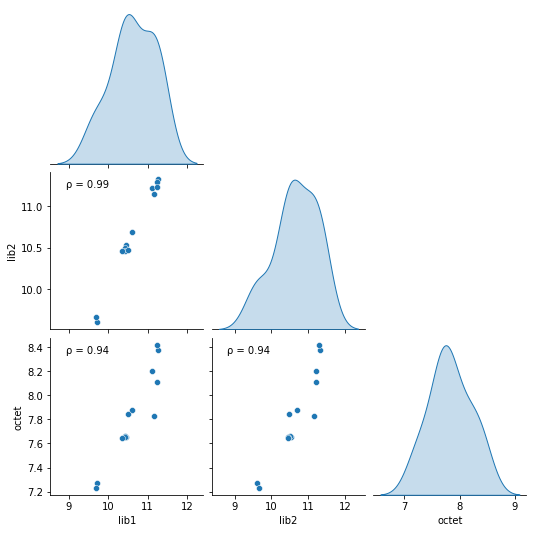

In [65]:
# now ggplot

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

g = sns.pairplot(shared_pivot, corner=True, diag_kind="kde")
g.map_lower(corrfunc)
g.savefig("lib-pairplot.png")
plt.show()

**now we can merge the dms libraries**

In [66]:
id_vars = ['aa_substitutions','aa_substitutions_IMGT','n_aa_substitutions', 'aa_sequence']
mean_collapsed_mutants = mutants.groupby(id_vars).mean().reset_index()
ge_prepped_df = mean_collapsed_mutants[id_vars + [f"delta_{metric}" for metric in new_cols] + new_cols]
ge_prepped_df = ge_prepped_df.assign(library="dms")
ge_prepped_df

,aa_substitutions,aa_substitutions_IMGT,n_aa_substitutions,aa_sequence,delta_bind,delta_stab,delta_poly,bind,stab,poly,library
0,A104C,A120(H)C,1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.043173,-0.058387,0.582997,10.398717,10.387853,7.600127,dms
1,A104C A173E,A120(H)C A52(L)E,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.345542,-0.652775,0.974194,10.096348,9.793465,7.991324,dms
2,A104C F137L,A120(H)C F10(L)L,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,0.263830,NaN,NaN,10.705720,NaN,NaN,dms
3,A104C G105V,A120(H)C G121(H)V,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-1.057929,-0.608318,1.809378,9.383961,9.837922,8.826508,dms
4,A104C G118S,A120(H)C G<NA>(link)S,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.163938,0.179599,0.091583,10.277952,10.625839,7.108713,dms
...,...,...,...,...,...,...,...,...,...,...,...
17536,Y94V S177W,Y103(H)V S56(L)W,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.592924,-0.610433,1.923054,9.848966,9.835807,8.940184,dms
17537,Y94V V130D K151T,Y103(H)V V3(L)D K24(L)T,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,0.114859,-0.505475,1.210357,10.556749,9.940765,8.227487,dms
17538,Y94V Y218T,Y103(H)V Y107(L)T,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-3.970501,-0.375578,NaN,6.471389,10.070662,NaN,dms
17539,Y94W,Y103(H)W,1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.246256,-0.072517,-0.122297,10.195634,10.373723,6.894833,dms


**toss out linker-mutant variants**

In [67]:
linker_idx_to_throw = [idx for idx, row in ge_prepped_df.iterrows() if "link" in row.aa_substitutions_IMGT]
ge_prepped_df = ge_prepped_df.drop(linker_idx_to_throw)
ge_prepped_df

,aa_substitutions,aa_substitutions_IMGT,n_aa_substitutions,aa_sequence,delta_bind,delta_stab,delta_poly,bind,stab,poly,library
0,A104C,A120(H)C,1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.043173,-0.058387,0.582997,10.398717,10.387853,7.600127,dms
1,A104C A173E,A120(H)C A52(L)E,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.345542,-0.652775,0.974194,10.096348,9.793465,7.991324,dms
2,A104C F137L,A120(H)C F10(L)L,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,0.263830,NaN,NaN,10.705720,NaN,NaN,dms
3,A104C G105V,A120(H)C G121(H)V,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-1.057929,-0.608318,1.809378,9.383961,9.837922,8.826508,dms
5,A104C L223F,A120(H)C L116(L)F,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.502703,-0.228924,1.035373,9.939187,10.217316,8.052503,dms
...,...,...,...,...,...,...,...,...,...,...,...
17536,Y94V S177W,Y103(H)V S56(L)W,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.592924,-0.610433,1.923054,9.848966,9.835807,8.940184,dms
17537,Y94V V130D K151T,Y103(H)V V3(L)D K24(L)T,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,0.114859,-0.505475,1.210357,10.556749,9.940765,8.227487,dms
17538,Y94V Y218T,Y103(H)V Y107(L)T,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-3.970501,-0.375578,NaN,6.471389,10.070662,NaN,dms
17539,Y94W,Y103(H)W,1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.246256,-0.072517,-0.122297,10.195634,10.373723,6.894833,dms


**linear calibration of octet data**

In [68]:
shared_var_dms = ge_prepped_df.query(f"aa_substitutions.isin({list(shared_oct_dms_vars)})").copy()
shared_var_octet = octet_df.query(f"aa_substitutions.isin({list(shared_oct_dms_vars)})").copy()

stacked = pd.concat([shared_var_dms, shared_var_octet], ignore_index=True)
stacked_pivot = stacked.pivot(index="aa_substitutions", columns="library", values="bind")
stacked_pivot

library,dms,octet
aa_substitutions,,
A161G,11.285620,8.375718
A161V,9.647251,7.267606
A173S,11.171021,8.204120
D27A,11.264855,8.419075
K39R,10.490956,7.651695
K44R,10.473852,7.665546
N219D,9.676041,7.232844
N219S,11.150341,7.826814
N219Y,11.225741,8.112383


**now, we want to fit a line, $y = mx + b$ through the octet and dms points. We're calibrating the octet data points so we'll call the vaiables. y_dms = slope * y_octet + intercept**.

**we can re-write the equation $y = Ap$, where $A = [[x, 1]]$ and $p = [[m], [c]]$**

In [69]:
x = stacked_pivot.octet.values
y = stacked_pivot.dms.values

A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
print(f"m (octet slope adjustment) = {m}")
print(f"c (octet intercept bias term) = {c}")

m (octet slope adjustment) = 1.4087592662073034
c (octet intercept bias term) = -0.3832259503528571


In [70]:
stacked_pivot = stacked_pivot.assign(octet_calibrated= lambda x: m*x.octet + c)
stacked_pivot

library,dms,octet,octet_calibrated
aa_substitutions,,,
A161G,11.285620,8.375718,11.416144
A161V,9.647251,7.267606,9.855082
A173S,11.171021,8.204120,11.174404
D27A,11.264855,8.419075,11.477224
K39R,10.490956,7.651695,10.396170
K44R,10.473852,7.665546,10.415683
N219D,9.676041,7.232844,9.806110
N219S,11.150341,7.826814,10.642870
N219Y,11.225741,8.112383,11.045168


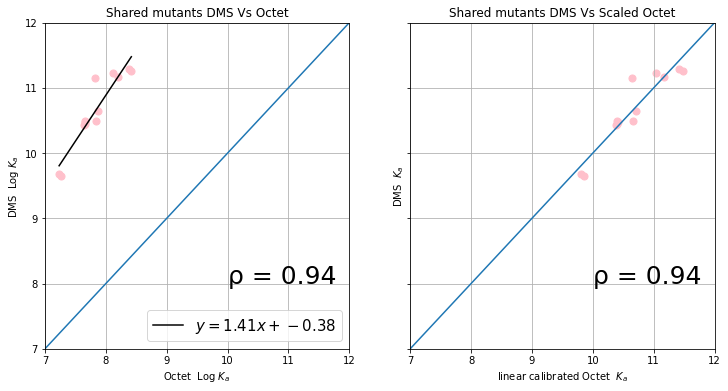

In [71]:
conv_func = lambda x: m*x + c
line_points = [[min(x), max(x)], [conv_func(min(x)), conv_func(max(x))]]
fig, ax = plt.subplots(1,2,figsize=[12,6], sharey=True, sharex=True)
ax[0].scatter(x, y, color="pink", s=50)
ax[0].set_ylabel("DMS  Log $K_{a}$")
ax[0].set_xlabel("Octet  Log $K_{a}$")
ax[0].set_title("Shared mutants DMS Vs Octet")
ax[0].grid()
r, _ = pearsonr(x, y)
ax[0].text(0.6, 0.2, f'ρ = {r:.2f}',transform=ax[0].transAxes, size=25)
ax[0].plot(*line_points, color="black", label=f"$y = {round(m, 2)}x + {round(c, 2)}$")
ax[0].legend(fontsize=15)
ax[0].set_ylim([7, 12])
ax[0].set_xlim([7, 12])
ax[0].plot([7, 12], [7, 12])

ax[1].scatter(stacked_pivot.octet_calibrated, y, color="pink", s=50)
ax[1].set_ylabel("DMS  $K_{a}$")
ax[1].set_xlabel("linear calibrated Octet  $K_{a}$")
ax[1].set_title("Shared mutants DMS Vs Scaled Octet")
ax[1].grid()
ax[1].plot([7, 12], [7, 12])
r, _ = pearsonr(stacked_pivot.octet_calibrated, y)
ax[1].text(0.6, 0.2, f'ρ = {r:.2f}',transform=ax[1].transAxes, size=25)
# ax[0].plot(*line_points, color="black", label=f"$y = {round(m, 3)}x + {round(c, 3)}$")
# ax[1].legend()

fig.savefig("shared-dms-octet-best-fit.png")
plt.show()

**now, grab all non shared variants**

In [72]:
# non_shared_var_octet = octet_df.query(f"~aa_substitutions.isin({list(shared_oct_dms_vars)})").copy()
# non_shared_var_octet

**Now, let's convert the points from non shared octet variants**

In [73]:
calibrated_octet_df = octet_df.assign(bind_cali=lambda x: m*x.bind + c)
calibrated_octet_df = calibrated_octet_df.assign(delta_bind_cali=lambda x: x.bind_cali - overall_wt_bind)
calibrated_octet_df

,library,delta_bind,bind,aa_substitutions,aa_substitutions_IMGT,n_aa_substitutions,aa_sequence,bind_cali,delta_bind_cali
0,octet,0.803749,8.546682,K44R Y53F A161G,K49(H)R Y58(H)F A40(L)G,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNRLE...,11.656991,1.230376
1,octet,0.842167,8.375718,A161G,A40(L)G,1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,11.416144,0.989529
2,octet,-0.192064,7.267606,A161V,A40(L)V,1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,9.855082,-0.571533
3,octet,-0.423735,7.148130,A161V N219D,A40(L)V N108(L)D,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,9.686769,-0.739846
4,octet,0.761498,8.419075,D27A,D28(H)A,1,EVQLQESGPSLVKPSQTLSLTCSVTGASITSGYWNWIRKFPGNKLE...,11.477224,1.050609
5,octet,2.488822,10.114074,D27A K39R S56G A161G Y163F A173S Q216H N219Y,D28(H)A K44(H)R S64(H)G A40(L)G Y42(L)F A52(L)...,8,EVQLQESGPSLVKPSQTLSLTCSVTGASITSGYWNWIRRFPGNKLE...,13.865069,3.438454
6,octet,2.583760,10.209012,D27A K44R S56G A161G Y163F A173S Q216H N219Y,D28(H)A K49(H)R S64(H)G A40(L)G Y42(L)F A52(L)...,8,EVQLQESGPSLVKPSQTLSLTCSVTGASITSGYWNWIRKFPGNRLE...,13.998814,3.572199
7,octet,2.557845,10.183096,D27A K39R K44R S56G A161G Y163F A173S Q216H N219Y,D28(H)A K44(H)R K49(H)R S64(H)G A40(L)G Y42(L)...,9,EVQLQESGPSLVKPSQTLSLTCSVTGASITSGYWNWIRRFPGNRLE...,13.962305,3.535690
8,octet,0.000000,7.585027,,,0,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,10.302251,-0.124364
9,octet,-0.005882,7.651695,K39R,K44(H)R,1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRRFPGNKLE...,10.396170,-0.030445


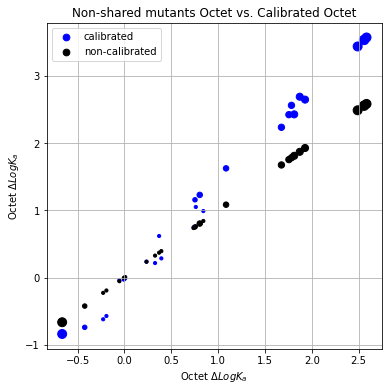

In [74]:
fig, ax = plt.subplots(figsize=[6,6])
non_cal = calibrated_octet_df.delta_bind
cal = calibrated_octet_df.delta_bind_cali
size = calibrated_octet_df.n_aa_substitutions * 10
ax.scatter(
    x=non_cal, 
    y=cal, 
    color="blue",
    label="calibrated",
    s=size
)
ax.scatter(
    x=non_cal, 
    y=non_cal, 
    color="black",
    label="non-calibrated",
    s = size
)
# for ((), ())
ax.set_xlabel("Octet $\Delta Log K_{a}$")
ax.set_ylabel("Octet $\Delta Log K_{a}$")
ax.set_title("Non-shared mutants Octet vs. Calibrated Octet")
ax.grid()
ax.legend()
fig.savefig("non-shared-octet-calibrated-scatter.png")

plt.show()

**Merge the non-shared, calibrated octet data with the dms library & mutant collapsed variants**

In [75]:
final = pd.concat([
    ge_prepped_df, 
    (calibrated_octet_df
     .drop(["delta_bind", "bind_cali"], axis=1)
     .rename({"delta_bind_cali":"delta_bind"}, axis=1)
    )
], ignore_index=True)
final

,aa_substitutions,aa_substitutions_IMGT,n_aa_substitutions,aa_sequence,delta_bind,delta_stab,delta_poly,bind,stab,poly,library
0,A104C,A120(H)C,1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.043173,-0.058387,0.582997,10.398717,10.387853,7.600127,dms
1,A104C A173E,A120(H)C A52(L)E,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.345542,-0.652775,0.974194,10.096348,9.793465,7.991324,dms
2,A104C F137L,A120(H)C F10(L)L,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,0.263830,NaN,NaN,10.705720,NaN,NaN,dms
3,A104C G105V,A120(H)C G121(H)V,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-1.057929,-0.608318,1.809378,9.383961,9.837922,8.826508,dms
4,A104C L223F,A120(H)C L116(L)F,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.502703,-0.228924,1.035373,9.939187,10.217316,8.052503,dms
...,...,...,...,...,...,...,...,...,...,...,...
17087,N219Y,N108(L)Y,1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,0.618553,NaN,NaN,8.112383,NaN,NaN,octet
17088,Q216H N219Y,Q105(L)H N108(L)Y,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1.157358,NaN,NaN,8.494850,NaN,NaN,octet
17089,N219D,N108(L)D,1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.620505,NaN,NaN,7.232844,NaN,NaN,octet
17090,K44R A161G Y163F A173S N219S,K49(H)R A40(L)G Y42(L)F A52(L)S N108(L)S,5,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNRLE...,2.647814,NaN,NaN,9.552842,NaN,NaN,octet


**Summarize the final data for fitting the global epistasis models**

(-5.0, 5.0)

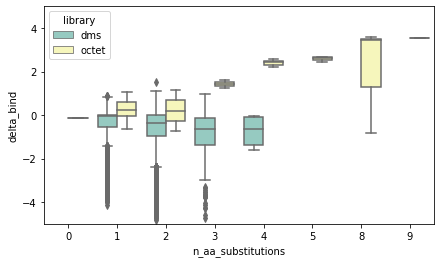

In [76]:
fig, ax = plt.subplots(figsize=[7, 4])
sns.boxplot(
    x="n_aa_substitutions", 
    y="delta_bind", 
    hue="library",
    data=final, 
    palette="Set3", 
    ax = ax
)
ax.set_ylim(-5,5)

**And now let's take a look at the final single mutants**

In [77]:
strata_counts = final.n_aa_substitutions.value_counts()
strata_counts

2    12314
1     4235
3      518
4       17
8        3
5        3
9        1
0        1
Name: n_aa_substitutions, dtype: int64

In [78]:
print(f"The total possible single mutants we should expect is (19 * (108+112)): {19 * (112 + 108)},"
      f" so why do we have {strata_counts[1]}?")

The total possible single mutants we should expect is (19 * (108+112)): 4180, so why do we have 4235?


is it because we still have duplicates?

In [79]:
final.query("n_aa_substitutions == 1").aa_substitutions.value_counts()

A173S    2
Y176F    2
S56G     2
Q216H    2
N219Y    2
        ..
L11W     1
L11Y     1
L174A    1
L174C    1
Y94W     1
Name: aa_substitutions, Length: 4222, dtype: int64

no ... do we still have linker mutations somewhere?

In [80]:
# linker_sites = pos_df.query("chain == 'link'").index.values
# for idx, row in final.query("n_aa_substitutions == 1").iterrows():
#     pos = int(row.aa_substitutions[1:-1])
#     assert "*" not in row.aa_substitutions
#     assert pos not in linker_sites

ah, okay can we throw "*"

In [81]:
final = final.drop([idx for idx, row in final.iterrows() if "*" in row.aa_substitutions])

In [84]:
# final

In [85]:
# final.n_aa_substitutions.value_counts()

okay, so now were just missing three muts. I'm assuming these are the three that were missing originally but were null anyway? i.e. ['I129F', 'I129L', 'S134R']

In [86]:
# final_single_muts = set(final.query("n_aa_substitutions == 1 & delta_bind.notnull()").aa_substitutions_IMGT)
# tyler_single_muts = set(tylers.query("bind_CGG.notnull() & WT == False").index)
# print(len(final_single_muts))
# print(len(tyler_single_muts))

In [87]:
# tyler_not_final = tyler_single_muts - final_single_muts
# tyler_not_final

In [88]:
# final_not_tyler = final_single_muts - tyler_single_muts
# final_not_tyler

In [89]:
# final_not_in_tyler_df = final.query(f"aa_substitutions_IMGT.isin({list(final_not_tyler)})")
# final_not_in_tyler_df

In [90]:
# tylers.query(f"index.isin({list(final_not_tyler)})")

In [91]:
# (
#     bind
#     .query(f"aa_substitutions.isin({list(final_not_in_tyler_df.aa_substitutions)})")
# #     .dropna()
# )

**Write ge prepped dataframe to disk**

# 9: `torchdms` prep

In [92]:
final

,aa_substitutions,aa_substitutions_IMGT,n_aa_substitutions,aa_sequence,delta_bind,delta_stab,delta_poly,bind,stab,poly,library
0,A104C,A120(H)C,1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.043173,-0.058387,0.582997,10.398717,10.387853,7.600127,dms
1,A104C A173E,A120(H)C A52(L)E,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.345542,-0.652775,0.974194,10.096348,9.793465,7.991324,dms
2,A104C F137L,A120(H)C F10(L)L,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,0.263830,NaN,NaN,10.705720,NaN,NaN,dms
3,A104C G105V,A120(H)C G121(H)V,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-1.057929,-0.608318,1.809378,9.383961,9.837922,8.826508,dms
4,A104C L223F,A120(H)C L116(L)F,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.502703,-0.228924,1.035373,9.939187,10.217316,8.052503,dms
...,...,...,...,...,...,...,...,...,...,...,...
17087,N219Y,N108(L)Y,1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,0.618553,NaN,NaN,8.112383,NaN,NaN,octet
17088,Q216H N219Y,Q105(L)H N108(L)Y,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1.157358,NaN,NaN,8.494850,NaN,NaN,octet
17089,N219D,N108(L)D,1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.620505,NaN,NaN,7.232844,NaN,NaN,octet
17090,K44R A161G Y163F A173S N219S,K49(H)R A40(L)G Y42(L)F A52(L)S N108(L)S,5,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNRLE...,2.647814,NaN,NaN,9.552842,NaN,NaN,octet


In [93]:
# write data w/ octet
with open(f"{prepped_dir}/dms-octet-cali.pkl", "wb") as f:
    pickle.dump([final, str(wtseq)], f)
    print(f"wrote {f}")

wrote <_io.BufferedWriter name='../nextflow/data/torchdms/prepped-dms/dms-octet-cali.pkl'>


In [94]:
# calibrated_octet_df.to_csv(f"{prepped_dir}/calibrated-octet-scores.csv")

**prep the data for tdms training**

In [95]:
! mkdir {prepped_dir}/dms-octet-cali/

mkdir: cannot create directory ‘../nextflow/data/torchdms/prepped-dms/dms-octet-cali/’: File exists


In [96]:
# prep baseline 
! tdms prep \
    --seed 23 \
    --per-stratum-variants-for-test 50 \
    --skip-stratum-if-count-is-smaller-than 200 \
    --train-on-all-single-mutants \
    --strata-ceiling 3 \
    {prepped_dir}/dms-octet-cali.pkl \
    {prepped_dir}/dms-octet-cali/data.prepped \
    delta_bind delta_stab

LOG: Setting random seed to 23.
LOG: Targets: ('delta_bind', 'delta_stab')
LOG: There are 16721 total variants in this dataset
LOG: placing all single mutants in training dataset as requested.
LOG: There are 4190 training samples for stratum: 1
LOG: There are 11918 training samples for stratum: 2
LOG: There are 412 training samples for stratum: 3
LOG: There are 100 validation samples
LOG: There are 100 test samples
LOG: Successfully partitioned data
LOG: preparing binary map dataset
LOG: Successfully finished prep and dumped SplitDataset object to ../nextflow/data/torchdms/prepped-dms/dms-octet-cali/data.prepped


In [97]:
! ls {prepped_dir}/dms-octet-cali

data.prepped.measurements.pdf  data.prepped.pkl


# 10: Final Variant Scores

In [98]:
tdms_prepped = pickle.load(open(f"{prepped_dir}/dms-octet-cali/data.prepped.pkl", "rb"))
tdms_prepped

**Go ahead and re-construct the original dataframe with the new added attributes**

In [119]:
final_reconstruct = pd.concat([t.test.original_df, t.val.original_df])
for strata in t.train:
    final_reconstruct = pd.concat([final_reconstruct, strata.original_df])
final_reconstruct

,aa_substitutions,aa_substitutions_IMGT,n_aa_substitutions,aa_sequence,delta_bind,delta_stab,delta_poly,bind,stab,poly,library,in_test,in_val,unseen_mutations
0,A91T T132L,A100(H)T T5(L)L,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-1.120389,-1.225703,1.614845,9.321501,9.220537,8.631975,dms,True,False,False
1,A96T D98S,A105(H)T D107(H)S,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.583298,0.062470,0.589685,9.858592,10.508710,7.606815,dms,True,False,False
2,C150W E208C,C23(L)W E97(L)C,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-1.318972,-2.448595,1.309087,9.122918,7.997645,8.326217,dms,True,False,False
3,C22H S134R G143P,C23(H)H S7(L)R G16(L)P,3,EVQLQESGPSLVKPSQTLSLTHSVTGDSITSGYWNWIRKFPGNKLE...,NaN,-3.872965,1.305743,NaN,6.573275,8.322873,dms,True,False,False
4,C22N S28T I233T,C23(H)N S29(H)T I126(L)T,3,EVQLQESGPSLVKPSQTLSLTNSVTGDTITSGYWNWIRKFPGNKLE...,-1.070922,-1.750284,0.657205,9.370968,8.695956,7.674335,dms,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,A161G Y163F A173S N219Y,A40(L)G Y42(L)F A52(L)S N108(L)Y,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.562305,NaN,NaN,9.492144,NaN,NaN,octet,False,False,NaN
408,A161G Y163F A173S Q216H N219Y,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)Y,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.690806,NaN,NaN,9.583359,NaN,NaN,octet,False,False,NaN
409,A161G Y163F A173S N219S,A40(L)G Y42(L)F A52(L)S N108(L)S,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.423506,NaN,NaN,9.393619,NaN,NaN,octet,False,False,NaN
410,A161G Y163F A173S Q216H N219S,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)S,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.428066,NaN,NaN,9.396856,NaN,NaN,octet,False,False,NaN


**How many of the octet data points ended up in test?**

**make the "split_set" and correct "n_aa_substitution" columns**

In [120]:
final_reconstruct = final_reconstruct.assign(split_set = ["train" for _ in range(len(final_reconstruct))])
final_reconstruct.loc[final_reconstruct.in_test, "split_set"] = "test"
final_reconstruct.loc[final_reconstruct.in_val, "split_set"] = "val"
final_reconstruct.drop(["in_test", "in_val"], axis=1, inplace=True)
final_reconstruct = final_reconstruct.rename({"n_aa_substitutions":"tdms_strata"}, axis =1)
final_reconstruct = final_reconstruct.assign(
    n_aa_substitutions = [
        len(aa_subs.split()) 
        if aa_subs == aa_subs else 0
        for aa_subs in final_reconstruct.aa_substitutions.values
    ]
)
final_reconstruct

,aa_substitutions,aa_substitutions_IMGT,tdms_strata,aa_sequence,delta_bind,delta_stab,delta_poly,bind,stab,poly,library,unseen_mutations,split_set,n_aa_substitutions
0,A91T T132L,A100(H)T T5(L)L,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-1.120389,-1.225703,1.614845,9.321501,9.220537,8.631975,dms,False,test,2
1,A96T D98S,A105(H)T D107(H)S,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.583298,0.062470,0.589685,9.858592,10.508710,7.606815,dms,False,test,2
2,C150W E208C,C23(L)W E97(L)C,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-1.318972,-2.448595,1.309087,9.122918,7.997645,8.326217,dms,False,test,2
3,C22H S134R G143P,C23(H)H S7(L)R G16(L)P,3,EVQLQESGPSLVKPSQTLSLTHSVTGDSITSGYWNWIRKFPGNKLE...,NaN,-3.872965,1.305743,NaN,6.573275,8.322873,dms,False,test,3
4,C22N S28T I233T,C23(H)N S29(H)T I126(L)T,3,EVQLQESGPSLVKPSQTLSLTNSVTGDTITSGYWNWIRKFPGNKLE...,-1.070922,-1.750284,0.657205,9.370968,8.695956,7.674335,dms,False,test,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,A161G Y163F A173S N219Y,A40(L)G Y42(L)F A52(L)S N108(L)Y,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.562305,NaN,NaN,9.492144,NaN,NaN,octet,NaN,train,4
408,A161G Y163F A173S Q216H N219Y,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)Y,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.690806,NaN,NaN,9.583359,NaN,NaN,octet,NaN,train,5
409,A161G Y163F A173S N219S,A40(L)G Y42(L)F A52(L)S N108(L)S,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.423506,NaN,NaN,9.393619,NaN,NaN,octet,NaN,train,4
410,A161G Y163F A173S Q216H N219S,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)S,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.428066,NaN,NaN,9.396856,NaN,NaN,octet,NaN,train,5


In [121]:
final_reconstruct.query("library == 'octet' & split_set == 'test'")

,aa_substitutions,aa_substitutions_IMGT,tdms_strata,aa_sequence,delta_bind,delta_stab,delta_poly,bind,stab,poly,library,unseen_mutations,split_set,n_aa_substitutions
99,D27A K44R S56G A161G Y163F A173S Q216H N219Y,D28(H)A K49(H)R S64(H)G A40(L)G Y42(L)F A52(L)...,3,EVQLQESGPSLVKPSQTLSLTCSVTGASITSGYWNWIRKFPGNRLE...,3.572199,NaN,NaN,10.209012,NaN,NaN,octet,False,test,8


In [122]:
final_reconstruct.to_csv(f"{prepped_dir}/final-multi-variant-scores.csv", index=False)